In [56]:
#Imports
import os
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from datetime import datetime
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

stop_token=[-1,-1,-1,-1]
np.set_printoptions(suppress=True, precision=2)

In [57]:
def extract_notes(midi_file):
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    notes = []
    for instrument in midi_data.instruments:
        if not instrument.is_drum:
            for note in instrument.notes:
                notes.append([note.start, note.pitch, note.velocity, note.end-note.start])
            #notes.append(stop_token)
    return sorted(notes, key=lambda x: x[0])

In [64]:
def normalize_notes(notes,scaler):
    notes = np.array(notes)
    normalized_notes = scaler.transform(notes)

    return normalized_notes

In [65]:
def create_sequences_sliding_window(notes, sequence_length, step_size):
    sequences = []
    next_notes = []
    for i in range(0, len(notes) - sequence_length, step_size):
        seq_in = notes[i:i + sequence_length]
        seq_out = notes[i + sequence_length]

        sequences.append(seq_in)
        next_notes.append(seq_out)

    return np.array(sequences), np.array(next_notes)

In [66]:
midi_dir = './smaller-dataset'
all_sequences = []
global_scaler = MinMaxScaler()

for midi_file in os.listdir(midi_dir):
    if midi_file.endswith('.mid') or midi_file.endswith('.midi'):
        notes = extract_notes(os.path.join(midi_dir, midi_file))
        global_scaler.partial_fit(notes)
        normalized_notes = normalize_notes(notes,global_scaler)
        #sequences,next_notes = create_sequences(normalized_notes, seq_length=30)
        sequences,next_notes = create_sequences_sliding_window(normalized_notes,32,16)

        all_sequences.extend(sequences)

In [67]:
class MIDIDataset(Dataset):
    def __init__(self, sequences, next_notes):
        self.sequences = sequences
        self.next_notes = next_notes

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32).clone().detach(), torch.tensor(self.next_notes[idx], dtype=torch.float32).clone().detach()

dataset = MIDIDataset(sequences, next_notes)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [68]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        #Added dropout to prevent overfitting
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        #Added Batch Normalisation
        #self.bn = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.to(device)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        #out = self.bn(out[:, -1, :])  # Applying batch normalization
        out = self.fc(out[:, -1, :])
        return out

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 4  # [start_time, pitch, velocity, duration]
hidden_size = 16
num_layers = 2
output_size=4

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
model.device=device

print('Using: ',model.device.type)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
#for hyperparameter testing
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, targets  in dataloader:
        inputs = inputs.to(model.device)
        targets = targets.to(model.device)
        optimizer.zero_grad()
        #forward pass
        outputs = model(inputs)
        
        #calculate loss
        loss = criterion(outputs, targets)
        
        #backward pass and optimize
        #optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()


    #print average loss for the epoch
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')



Using:  cuda
Epoch [1/5], Average Loss: 0.1643
Epoch [2/5], Average Loss: 0.0297
Epoch [3/5], Average Loss: 0.0145
Epoch [4/5], Average Loss: 0.0135
Epoch [5/5], Average Loss: 0.0131


In [70]:
filename = f"./models/model_{datetime.now():%d_%m_%H_%M}.pth"
torch.save(model.state_dict(), filename)
print('Model saved')

Model saved


In [71]:
def generate_music(model, start_sequence, length):
    model.eval()
    generated_sequence = start_sequence.tolist()
    current_sequence = start_sequence

    for i in range(length):
        current_sequence_tensor = torch.tensor(current_sequence, dtype=torch.float32).unsqueeze(0).to(model.device)
        # Generate next note
        next_note = model(current_sequence_tensor).detach().cpu().numpy().squeeze(0)
        next_note_denormalized = global_scaler.inverse_transform(next_note.reshape(1, -1)).flatten()
        #print(f"Step {i+1}, Current Sequence: {current_sequence}")
        print(f"Step {i+1}, Next Note: {next_note_denormalized}")
        generated_sequence.append(next_note_denormalized.tolist())
        current_sequence = np.append(current_sequence[1:], [next_note], axis=0)

    # Convert the generated sequence to a NumPy array and trim the initial input sequence
    return np.array(generated_sequence)[len(start_sequence):]
    #return np.array(generated_sequence)

#generate the sequence using your model
start_sequence = sequences[1]
#or pick random
#start_sequence = random.choice(sequences)
#generate n notes
generated_sequence = generate_music(model, start_sequence, 10)

print('Slice of prediction from normalised data')
print(generated_sequence.shape)
#denormalized_sequence = denormalize_notes(generated_sequence, global_scaler)


Step 1, Next Note: [424.35  67.57  70.59   0.01]
Step 2, Next Note: [424.44  67.6   70.74   0.03]
Step 3, Next Note: [424.52  67.69  70.85   0.03]
Step 4, Next Note: [424.58  67.76  70.95   0.03]
Step 5, Next Note: [424.63  67.83  71.04   0.03]
Step 6, Next Note: [424.68  67.88  71.11   0.03]
Step 7, Next Note: [424.73  67.92  71.17   0.03]
Step 8, Next Note: [424.77  67.96  71.22   0.03]
Step 9, Next Note: [424.81  67.99  71.26   0.03]
Step 10, Next Note: [424.85  68.01  71.29   0.03]
Slice of prediction from normalised data
(10, 4)


In [72]:
# define the MIDI conversion function
def sequence_to_midi(denormalized_sequence, output_path):
    midi = pretty_midi.PrettyMIDI()
    #program is piano
    instrument = pretty_midi.Instrument(program=0)
    
    for i,note in enumerate(denormalized_sequence):
        #first note starts at 0 and the next notes should take the previous notes starting point and add the duration of self
        start = 0.0 if i == 0 else instrument.notes[-1].end
        pitch = int(note[1])
        velocity = int(note[2])
        duration = note[3]

        if not (0 <= velocity <= 127):
            continue
        if not (0 <= pitch <= 127):
            continue
        midi_note = pretty_midi.Note(
            velocity=velocity,
            pitch=pitch,
            start=start,
            end=start+duration
            #end=start+duration+1.5
        )
        #print(midi_note)
        instrument.notes.append(midi_note)
    print('Total notes:',len(instrument.notes))
    print('Slice of generated notes for debugging')
    #print(instrument.notes[0:10])
    midi.instruments.append(instrument)
    
    try:
        midi.write(output_path)
        print(f"Generated MIDI file saved to {output_path}")
    except ValueError:
        print('error here',ValueError)

output_path = f"./generated_music_{datetime.now():%d_%m_%H_%M}.mid"
sequence_to_midi(generated_sequence, output_path)


Total notes: 10
Slice of generated notes for debugging
Generated MIDI file saved to ./generated_music_19_06_00_55.mid


In [73]:
# Load MIDI file
midi_file = output_path
midi_data = pretty_midi.PrettyMIDI(midi_file)

#extract notes from the first instrument
notes = midi_data.instruments[0].notes

#extract start times, pitches, and durations
start_times = np.array([note.start for note in notes])
end_times = np.array([note.end for note in notes])
durations = end_times - start_times
pitches = np.array([note.pitch for note in notes])

#normalize the pitch column (second column) to [0, 1] range
min_pitch = 0  #MIDI pitch minimum value
max_pitch = 127  #MIDI pitch maximum value
normalized_pitches = (pitches - min_pitch) / (max_pitch - min_pitch)

#function to map MIDI pitch number to note name
def midi_to_note_name(midi_num):
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = (midi_num // 12) - 1
    note = note_names[midi_num % 12]
    return f"{note}{octave}"


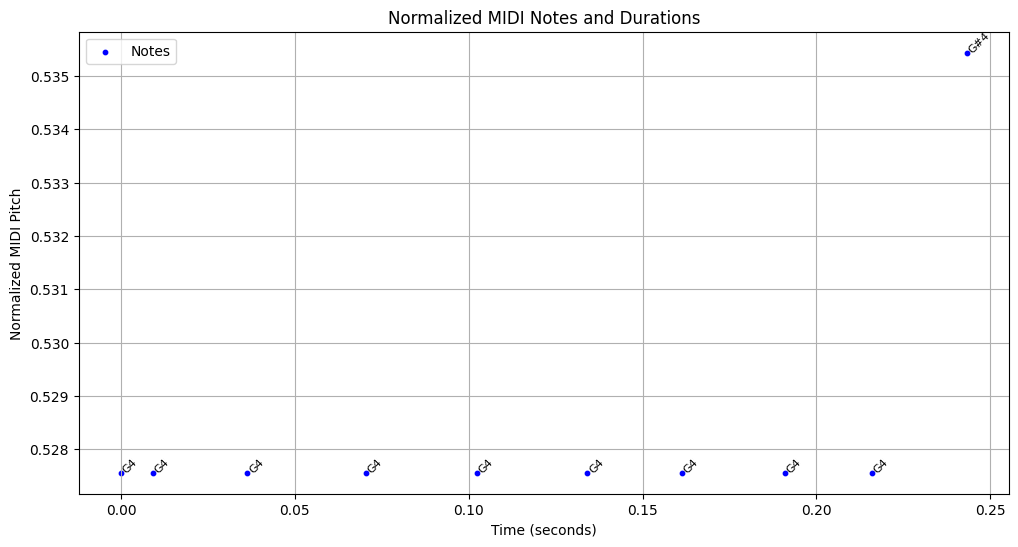

In [74]:
#map normalized pitch values back to note names
note_names = [midi_to_note_name(int(pitch * 127)) for pitch in normalized_pitches]

plt.figure(figsize=(12, 6))
plt.scatter(start_times, normalized_pitches, s=10, label='Notes', color='blue')
plt.xlabel('Time (seconds)')
plt.ylabel('Normalized MIDI Pitch')
plt.title('Normalized MIDI Notes and Durations')
plt.legend()
plt.grid(True)

#labels
for i, txt in enumerate(note_names):
    plt.annotate(txt, (start_times[i], normalized_pitches[i]), fontsize=8, rotation=45)

plt.show()